In [66]:
# Import Dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [67]:
#Choose a start date and end date for your trip. 3-15 days total.
## I have chosen August 1-7 for this assignment

In [68]:
#Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///hawaii.sqlite")

In [69]:
#Use SQLAlchemy automap_base() to reflect your tables into classes
##save a reference to those classes called Station and Measurement.
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'station']

In [70]:
##save a reference to those classes called Station and Measurement.
inspector = inspect(engine)
inspector.get_table_names()

# Reflect Database into ORM class
Station = Base.classes.station
Measurements = Base.classes.measurements

# Start a session to query the database
session = Session(engine)

In [71]:
########3a Precipitation Analysis

In [72]:
# Figure out last day of entry so we can figure out what 1 year of data time span is
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

##Spoiler alert, it's August 23 of 2017

('2017-08-23',)


In [73]:
# get date of 1 year before last entry found above, <last date - 365>
Rewind_Year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(Rewind_Year)

2016-08-23


In [74]:
#Design a query to retrieve the last 12 months of precipitation data.
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > Rewind_Year).\
    order_by(Measurements.date).all()

In [75]:
# Load the query results into a Pandas DataFrame and set the index to the date column.

rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


In [76]:
# Set the index to the date column.

rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


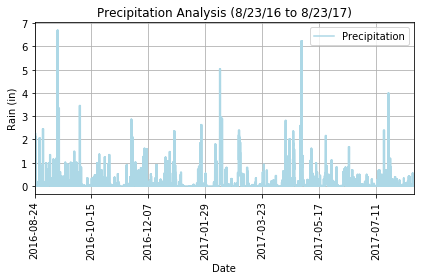

In [77]:
# Plot
rain_df.plot('date', 'prcp', c="lightblue")
plt.xlabel("Date")
plt.ylabel("Rain (in)")
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

In [78]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,6669.000000
mean,0.159951
std,0.441154
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [79]:
########3b Station Analysis

In [80]:
# Design a query to calculate the total number of stations.
locations = session.query(Measurements).group_by(Measurements.station).count()

In [81]:
# Print number of total stations
print(locations)

9


In [82]:
#Design a query to find the most active stations.
##List the stations and observation counts in descending order
###Which station has the highest number of observations?

station_activity = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest_station = station_activity[0][0]    

print("The busiest Station is",busiest_station,"with",station_activity[0][1],"weather observations.")
print()
print("Here are all of the Stations with their number of observations:")
for station, count in station_activity:
    print("Station",station,"had",count, "weather observations.")

The busiest Station is USC00519281 with 8316 weather observations.

Here are all of the Stations with their number of observations:
Station USC00519281 had 8316 weather observations.
Station USC00519397 had 8172 weather observations.
Station USC00513117 had 8127 weather observations.
Station USC00519523 had 8007 weather observations.
Station USC00516128 had 7836 weather observations.
Station USC00514830 had 6606 weather observations.
Station USC00511918 had 5937 weather observations.
Station USC00517948 had 4116 weather observations.
Station USC00518838 had 1533 weather observations.


In [83]:
# Precipitation data for busiest station
Rain = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > Rewind_Year).\
    order_by(Measurements.date).all()

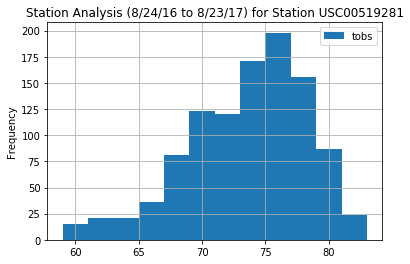

In [84]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(Rain)
plt.hist(temp_df['tobs'],12)
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.legend(["tobs"])
plt.grid(True)
plt.show()

In [85]:
########3c Temperature Analysis

In [86]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(62, 69.57142857142857, 74)]


In [87]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2018, 8, 1)
trip_leave = dt.date(2018, 8, 7)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(72, 79.25, 83)]


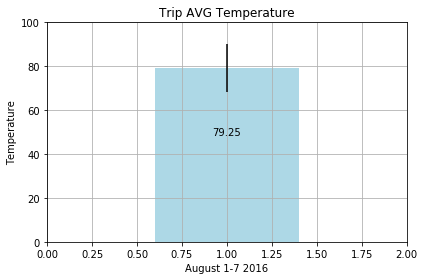

In [89]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'lightblue', yerr=p2p)
ax.set_xlabel("August 1-7 2016")
ax.set_ylabel("Temperature")
ax.set_title("Trip AVG Temperature")
        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
plt.grid(True)
fig.tight_layout()
plt.show()